Correlation and distance analysis between Gene expression and ATAC-seq data


After analyzing the ATAC-seq and RNA-seq datasets doing different clusters we want to see how gene expression and ATAC-seq regions correlate and analyze the distance between genes and CREs. This will give use important information to uncover regulatory programms from ILCs.

In this Notebook we are going to be solving the following questions:

2. iii Can one use correlation analysis and distance information to associate ATAC-seq regions with gene expression?

a) Where are associated CREs located with respect to the TSS?
b) Where are the most associated CREs located?
c) How many CREs are associated with genes?
d) Is every promoter associated with a gene?
e) Are some promoters associated with other genes?
f) What is the closest associated CRE to a gene?
g) Are there CREs that control several genes?

To do this, we are going to use different statistical methods such as Pearson correlation. The results are visualized in some cases using plots, histograms and heatmaps. 

1. Load the datasets, filtering, obtaining TSS per each gene and associating OCRs with near genes 

In [112]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
atac = pd.read_csv("data/ImmGenATAC18_AllOCRsInfo.csv")
rna = pd.read_csv("data/mmc2.csv")
refflat = pd.read_csv("data/refFlat.txt", sep="\t", header=None)
refflat.columns = [
    "geneName", "name2", "chrom", "strand", "txStart", "txEnd",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"
]


In [ ]:
cell_types = [
    "NK.27+11b-.BM", "NK.27+11b+.BM", "NK.27-11b+.BM",
    "NK.27+11b-.Sp", "NK.27+11b+.Sp", "NK.27-11b+.Sp",
    "ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI"
]


In [ ]:
rna = rna.rename(columns={"Unnamed: 0": "gene"})
rna_filtered = rna.set_index("gene")[cell_types]

atac = atac[atac[cell_types].notnull().all(axis=1)].copy()
atac["midpoint"] = atac["Summit"]
atac_filtered = atac[["ImmGenATAC1219.peakID", "chrom", "midpoint", "genes.within.100Kb"] + cell_types]


In [ ]:
refflat["TSS"] = np.where(refflat["strand"] == "+", refflat["txStart"], refflat["txEnd"])
gene_tss = refflat[["geneName", "chrom", "TSS"]].drop_duplicates()

In [ ]:
rows = []
window = 100_000

for i, row in atac_filtered.iterrows():
    peak_id = row["ImmGenATAC1219.peakID"]
    chrom = row["chrom"]
    midpoint = row["midpoint"]
    signal = row[cell_types].values
    if pd.isna(row["genes.within.100Kb"]):
        continue

    genes = [g.strip() for g in str(row["genes.within.100Kb"]).split(";")]
    for gene in genes:
        if gene in rna_filtered.index and gene_tss["geneName"].eq(gene).any():
            gene_row = gene_tss[gene_tss["geneName"] == gene]
            gene_chrom = gene_row["chrom"].values[0]
            tss = gene_row["TSS"].values[0]

            if gene_chrom != chrom:
                continue

            expr = rna_filtered.loc[gene].values
            corr, _ = pearsonr(signal, expr)

            rows.append({
                "ocr_id": peak_id,
                "gene": gene,
                "chrom": chrom,
                "distance": midpoint - tss,
                "abs_distance": abs(midpoint - tss),
                "correlation": corr
            })

assoc_df = pd.DataFrame(rows)
print("Associations OCR ↔ gen:", assoc_df.shape)

/var/folders/cy/bvr0t8gn719b64ym133x5y7m0000gn/T/ipykernel_99327/1902175718.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(signal, expr)


Asociaciones OCR ↔ gen: (98593, 6)


2. Calculating average correlation to see if it is viable to use it for further analysis. The average correlation is 0.04, positive but very close to zero. This means that Gene expression does not correlate very well with OCRs, that could be because not all OCRs influence gene expression directly or some of them could be repressors or silencers.

In [113]:
print("Average Correlation:", assoc_df["correlation"].mean())

Average Correlation: 0.04338660211201527


3. Answering question a). We can determine from the plot that CREs are located mostly on TSSs or very close to them.

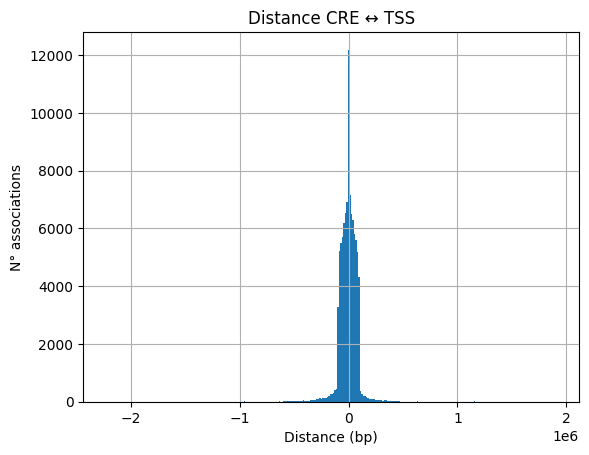

In [126]:
plt.figure()
assoc_df["distance"].hist(bins=300)
plt.title("Distance CRE ↔ TSS")
plt.xlabel("Distance (bp)")
plt.ylabel("N° associations")
plt.show()

4. Answering question b). The following table shows how far away are the most associated CREs to each gene located.

In [115]:
top_assoc = assoc_df.sort_values(by="correlation", ascending=False).head(10)
print("TOP 10 more associated CREs:\n", top_assoc)

TOP 10 more associated CREs:
                            ocr_id           gene  chrom  distance  \
40425  ImmGenATAC1219.peak_203677           Ets2  chr16   46963.0   
20608  ImmGenATAC1219.peak_108346  9430078K24Rik  chr12  -67017.0   
83435  ImmGenATAC1219.peak_428162           Nav2   chr7  292471.0   
74141  ImmGenATAC1219.peak_375291         Ptpn13   chr5   72435.0   
31260  ImmGenATAC1219.peak_161017           Klf5  chr14    9258.0   
51545  ImmGenATAC1219.peak_259218  1700061F12Rik   chr2  -33760.0   
74143  ImmGenATAC1219.peak_375293         Ptpn13   chr5   76079.0   
83394  ImmGenATAC1219.peak_428121           Nav2   chr7  218066.0   
8362    ImmGenATAC1219.peak_38111        Plekhg1  chr10  123258.0   
81197  ImmGenATAC1219.peak_410833          Pparg   chr6  -56902.0   

       abs_distance  correlation  
40425       46963.0     0.999173  
20608       67017.0     0.999055  
83435      292471.0     0.998503  
74141       72435.0     0.998258  
31260        9258.0     0.998164  


5. Answering question c). There are 98593 CREs associated to genes. 

In [116]:
print("CREs associated to genes:", assoc_df["ocr_id"].nunique())

CREs associated to genes: 98593


6. Answering question d) and e). There are 1750 genes with CREs on their promoters, a small number when compared to the total numbers of CREs associated to genes, which means that the majority of CREs are enhancers. There are no promoters associated with more than 1 gene.

In [87]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Archivos
atac_path = "data/ImmGenATAC18_AllOCRsInfo.csv"
rna_path = "data/mmc2.csv"
refFlat_path = "data/refFlat.txt"

# Cargar ATAC-seq
atac = pd.read_csv(atac_path)
atac["midpoint"] = atac["Summit"]

# Tipos celulares de interés
cell_types = [
    "NK.27+11b-.BM", "NK.27+11b+.BM", "NK.27-11b+.BM",
    "NK.27+11b-.Sp", "NK.27+11b+.Sp", "NK.27-11b+.Sp",
    "ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI"
]
atac_filtered = atac[["ImmGenATAC1219.peakID", "chrom", "midpoint", "genes.within.100Kb"] + cell_types].dropna()

# RNA-seq
rna = pd.read_csv(rna_path)
rna.columns.values[0] = "gene"
rna.set_index("gene", inplace=True)
rna_filtered = rna[cell_types].dropna()

# RefFlat
refFlat = pd.read_csv(refFlat_path, sep="\t", header=None, names=[
    "geneName", "transcript", "chrom", "strand", "txStart", "txEnd",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"
])
refFlat = refFlat[refFlat["chrom"].str.startswith("chr")]
refFlat["TSS"] = np.where(refFlat["strand"] == "+", refFlat["txStart"], refFlat["txEnd"])
gene_tss = refFlat.groupby("geneName")[["chrom", "TSS"]].first().reset_index()

In [ ]:
rows = []
for i, row in atac_filtered.iterrows():
    peak_id = row["ImmGenATAC1219.peakID"]
    chrom = row["chrom"]
    midpoint = row["midpoint"]
    signal = row[cell_types].values
    genes = str(row["genes.within.100Kb"]).split(";")

    for gene in genes:
        gene = gene.strip()
        if gene in rna_filtered.index and gene_tss["geneName"].eq(gene).any():
            gene_row = gene_tss[gene_tss["geneName"] == gene]
            gene_chrom = gene_row["chrom"].values[0]
            tss = gene_row["TSS"].values[0]
            if gene_chrom != chrom:
                continue
            expr = rna_filtered.loc[gene].values
            corr, _ = pearsonr(signal, expr)

            rows.append({
                "ocr_id": peak_id,
                "gene": gene,
                "chrom": chrom,
                "distance": midpoint - tss,
                "abs_distance": abs(midpoint - tss),
                "correlation": corr
            })

assoc_df = pd.DataFrame(rows)
assoc_df.to_csv("assoc_df.csv", index=False) 

/var/folders/cy/bvr0t8gn719b64ym133x5y7m0000gn/T/ipykernel_99327/705913076.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(signal, expr)


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

promoter_assoc = assoc_df[assoc_df["abs_distance"] <= 2000]
genes_with_promoter = promoter_assoc["gene"].nunique()
print("Genes with CREs in promoter:", genes_with_promoter)

multi_gene_promoters = promoter_assoc.groupby("ocr_id")["gene"].nunique()
multi_gene_promoters = multi_gene_promoters[multi_gene_promoters > 1]
print("Promoters associated to more than 1 gene:", multi_gene_promoters.shape[0])


Genes with CREs in promoter: 1750
Promoters associated to more than 1 gene: 0


7. Answering question f). On the table we are able to see 30 genes and its closest CRE in order to visualize the results.

In [ ]:
closest = assoc_df.loc[assoc_df.groupby("gene")["abs_distance"].idxmin()]
print("closest CREs to each gene (first 30):\n", closest.head(30))

closest CREs to each gene (first 30):
                            ocr_id           gene  chrom  distance  \
17557   ImmGenATAC1219.peak_85693  0610039H22Rik  chr11   -4041.0   
72410  ImmGenATAC1219.peak_367960  0610040J01Rik   chr5     -18.0   
61814  ImmGenATAC1219.peak_307975  1110032F04Rik   chr3     -33.0   
12299   ImmGenATAC1219.peak_55487  1500009L16Rik  chr10   27517.0   
40511  ImmGenATAC1219.peak_203766  1600002D24Rik  chr16  -41186.0   
41143  ImmGenATAC1219.peak_206470  1700010I14Rik  chr17     -53.0   
85471  ImmGenATAC1219.peak_439918  1700012D14Rik   chr7   61999.0   
65534  ImmGenATAC1219.peak_325847  1700012D16Rik   chr3    -229.0   
2001     ImmGenATAC1219.peak_7328  1700019D03Rik   chr1  -32299.0   
5937    ImmGenATAC1219.peak_25637  1700025G04Rik   chr1      44.0   
72553  ImmGenATAC1219.peak_368249  1700027F09Rik   chr5  -90975.0   
11095   ImmGenATAC1219.peak_46782  1700027J07Rik  chr10  -22378.0   
76006  ImmGenATAC1219.peak_389321  1700028E10Rik   chr5  -65521.

8. Answering question g). Yes there are many CREs that regulate more than one gene. This can be visualized in the histogram and the heatmap. This is an expected result according to biological literature. There are even genes such as Foxp1 that are associated with 383 genes.

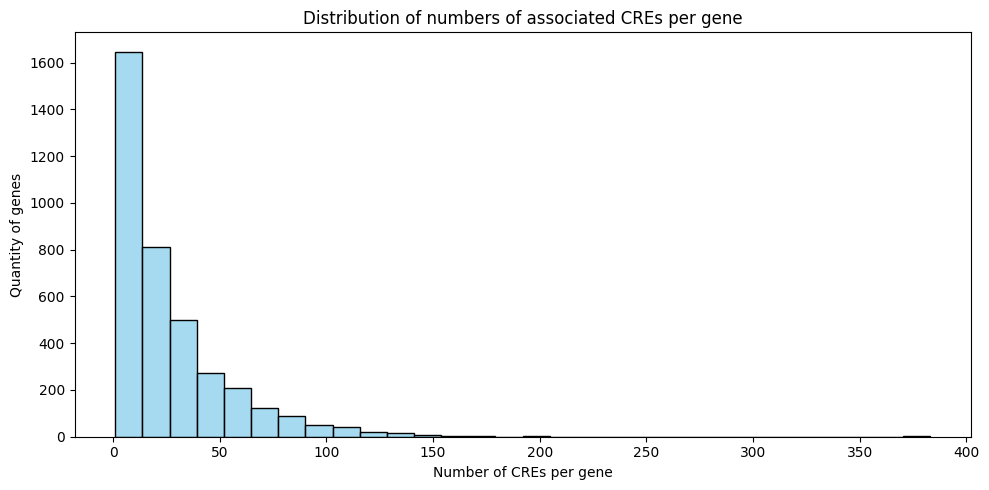

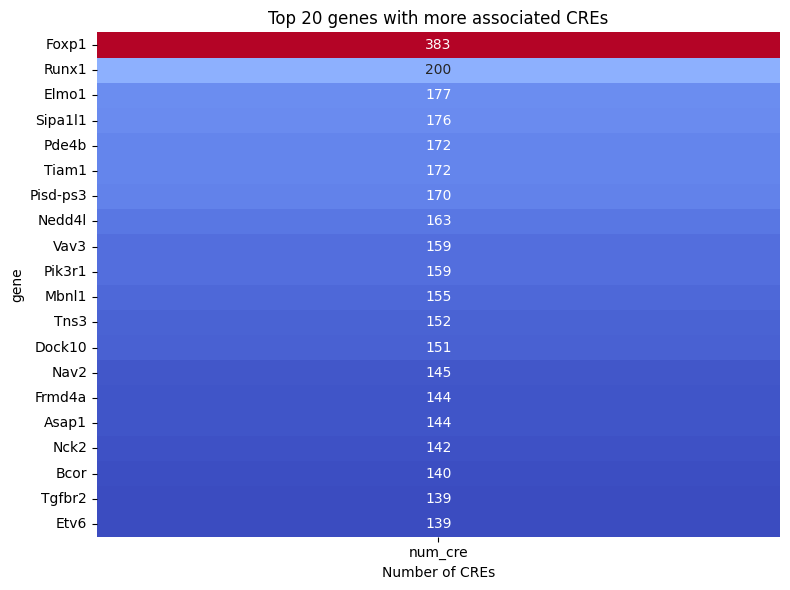

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assoc_df = pd.read_csv("assoc_df.csv")

cre_count_per_gene = assoc_df.groupby("gene")["ocr_id"].nunique().reset_index()
cre_count_per_gene.columns = ["gene", "num_cre"]

multi_cre_genes = cre_count_per_gene[cre_count_per_gene["num_cre"] > 1]

plt.figure(figsize=(10, 5))
sns.histplot(cre_count_per_gene["num_cre"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of numbers of associated CREs per gene")
plt.xlabel("Number of CREs per gene")
plt.ylabel("Quantity of genes")
plt.tight_layout()
plt.show()

top_genes = multi_cre_genes.sort_values("num_cre", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.heatmap(top_genes.set_index("gene"), annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Top 20 genes with more associated CREs")
plt.xlabel("Number of CREs")
plt.tight_layout()
plt.show()

9. Visualization of closest CRE to each gene with histograms, heatmaps and barplots

In [ ]:
import pandas as pd

atac = pd.read_csv("data/ImmGenATAC18_AllOCRsInfo.csv")
refFlat = pd.read_csv("data/refFlat.txt", sep="\t", header=None)

refFlat.columns = ["geneName", "name", "chrom", "strand", "txStart", "txEnd", "cdsStart", "cdsEnd",
                   "exonCount", "exonStarts", "exonEnds"]

refFlat["TSS"] = refFlat.apply(lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"], axis=1)
gene_tss = refFlat.groupby("geneName")[["chrom", "TSS"]].first().reset_index()

atac = atac.rename(columns={"ImmGenATAC1219.peakID": "ocr_id"})
atac["midpoint"] = atac["Summit"].astype(int)

atac_sub = atac[["ocr_id", "chrom", "midpoint"]].copy()

closest = []
for _, row in gene_tss.iterrows():
    gene, chrom, tss = row["geneName"], row["chrom"], row["TSS"]
    nearby = atac_sub[(atac_sub["chrom"] == chrom) &
                      (abs(atac_sub["midpoint"] - tss) <= 100_000)].copy()
    if not nearby.empty:
        nearby["distance"] = abs(nearby["midpoint"] - tss)
        closest_ocr = nearby.loc[nearby["distance"].idxmin()]
        closest.append({
            "gene": gene,
            "ocr_id": closest_ocr["ocr_id"],
            "distance_to_tss": closest_ocr["distance"]
        })

closest_df = pd.DataFrame(closest)
closest_df.to_csv("closest_cre_per_gene.csv", index=False)
print(closest_df.head())

            gene                      ocr_id  distance_to_tss
0  0610005C13Rik  ImmGenATAC1219.peak_427235             1003
1  0610009B22Rik   ImmGenATAC1219.peak_75289              163
2  0610009E02Rik  ImmGenATAC1219.peak_263173               25
3  0610009L18Rik   ImmGenATAC1219.peak_95335               68
4  0610010F05Rik   ImmGenATAC1219.peak_70328               94


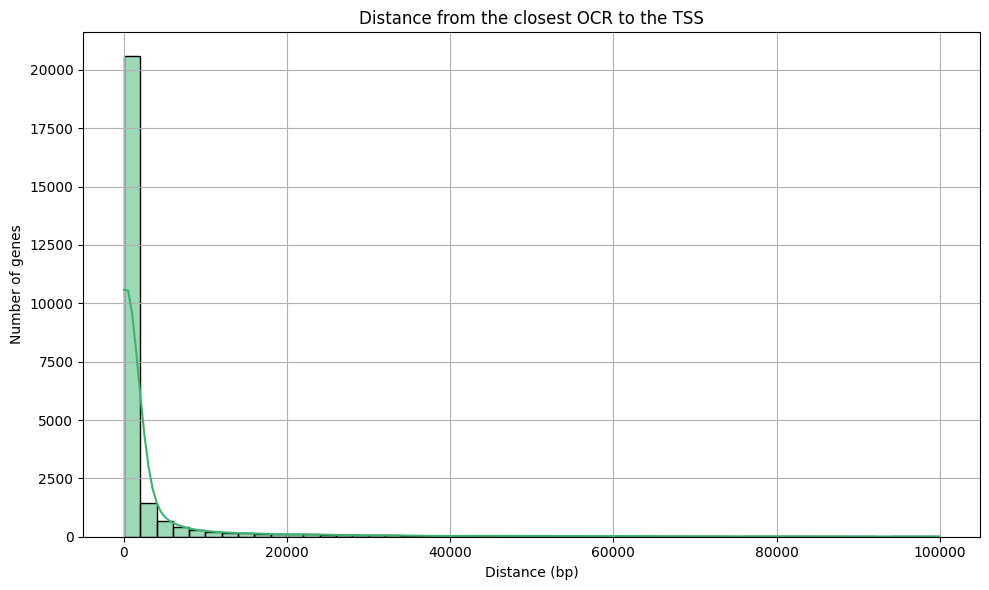

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("closest_cre_per_gene.csv")

plt.figure(figsize=(10, 6))
sns.histplot(df["distance_to_tss"], bins=50, kde=True, color='mediumseagreen')
plt.title("Distance from the closest OCR to TSS")
plt.xlabel("Distance (bp)")
plt.ylabel("Number of genes")
plt.grid(True)
plt.tight_layout()
plt.show()

Most of the genes have their closest OCR near the TSS, which was expected because all genes have promoters. The situations where the closest OCR is more than 2kb away from the TSS can also be realistic because not all promoters were available by the time of the experiment. 

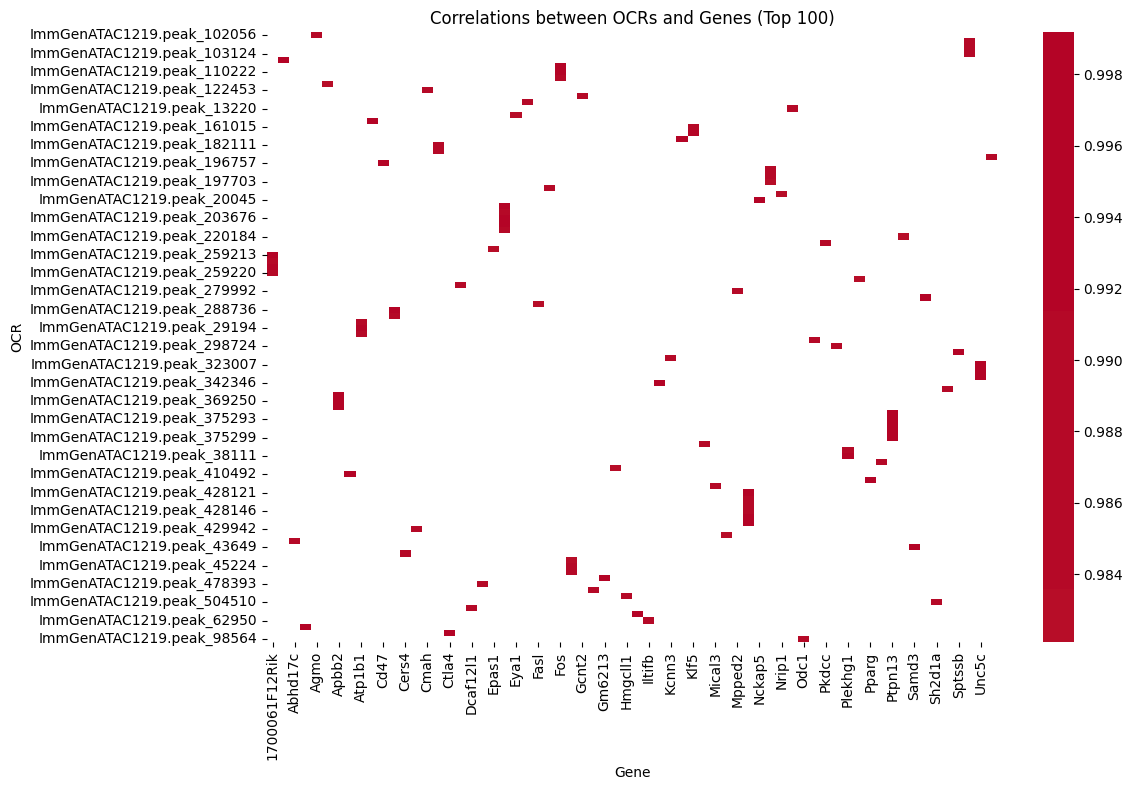

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

top_assoc = assoc_df.sort_values("correlation", ascending=False).head(100)

pivot = top_assoc.pivot(index="ocr_id", columns="gene", values="correlation")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap="coolwarm", center=0)
plt.title("Correlations between OCRs and Genes (Top 100)")
plt.xlabel("Gene")
plt.ylabel("OCR")
plt.tight_layout()
plt.show()

This heatmap portrays the highest correlations between OCRs and genes. As seen, many of the OCRs correlate with more than one gene. Also some genes correlate with more than one OCR, which makes sense because genes have both promoters and enhancers. 

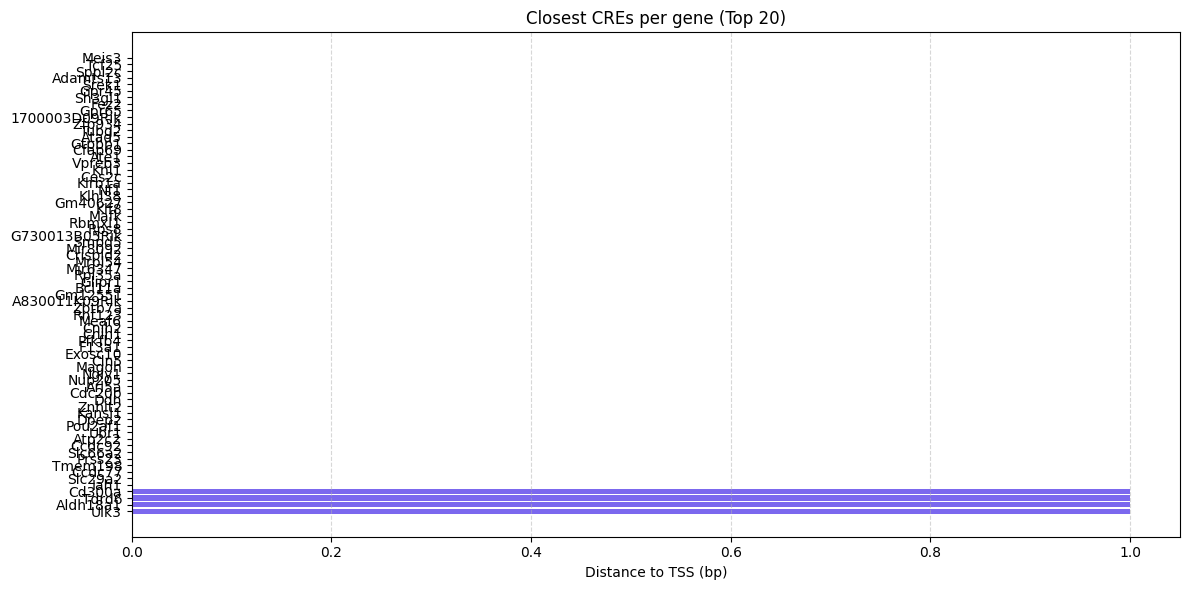

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("closest_cre_per_gene.csv", nrows=None) 

df['distance_to_tss'] = pd.to_numeric(df['distance_to_tss'], errors='coerce')

df = df.dropna(subset=['distance_to_tss'])

df_top = df.sort_values("distance_to_tss", key=abs).head(70)

plt.figure(figsize=(12, 6))
plt.barh(df_top['gene'], df_top['distance_to_tss'], color="mediumslateblue")
plt.xlabel("Distance to TSS (bp)")
plt.title("Closest CREs per gene (Top 20)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

This Grafic proved again that most of the closest CREs per gene are promoters and are therefore located in very close proximity to the gene